In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.optimize import fsolve

sn.set_style('whitegrid')
%matplotlib inline

In [3]:
# Expanded and modified version (first column now string)
def read_table(filename,keyword='ciclo',rescale=1,ncols=5,start=2,end_row='Total',
               endword=None,omit_list=['t20_21'],index_to_int=True,debug=False):
    t0 = start
    t1 = ncols+start
    results_follow = 0
    row_names = []
    f = open(filename,'r')
    for line in f:
        words = line.split()
        if debug:
            print(words)
        if len(words)>1 and words[0] == keyword:
            results_follow=1
            if endword==None:
                colnames = words[t0:t1]
            else:
                buff_v = []
                for w in words[t0:]:
                    if w==endword:
                        break
                    else:
                        buff_v.append(w)
                colnames = buff_v[:-1]
                t1 = len(buff_v)+t0-1
            table_raw = np.empty(t1-t0)
        elif len(words)>1 and words[0] == end_row:
            break
        elif len(words)>1 and results_follow==1 and words[0] not in omit_list:
            row_names.append(words[0])
            buff_v = []
            for w in words[t0:t1]: 
                w = w.replace(",","")
                buff_v.append(w)
            table_raw = np.vstack((table_raw,np.array(buff_v,dtype=float)/rescale))
    table_raw = table_raw[1:,:]
    if debug:
        print(table_raw.shape)
        print(colnames)
    if index_to_int:
        return pd.DataFrame(table_raw, columns=colnames,index=np.array(row_names,dtype=int))
    else:
        return pd.DataFrame(table_raw, columns=colnames,index=np.array(row_names))
    
    
def file_split(filename,path,startwords=['Summary',],endword="Total",header=None):
    f = open(path+filename,'r')
    parent_file = filename[:filename.find('.')]
    di = 1
    writing = 0
    for line in f:
        words = line.split()
        if len(words)>0 and words[0] in startwords:
            sf = open(path+parent_file+'_{}.log'.format(di), "w")
            writing = 1
            if header!=None:
                sf.write(header)
        elif len(words)>0 and words[0]==endword and writing:
            sf.write(line)
            writing = 0
            sf.close()
            di+=1
        if writing:
            sf.write(line)
            
def normalise_table(table):
    cols = table.columns
    table['Total'] = table.sum(axis=1).copy()
    for col in cols:
        table[col] = table[col]/table['Total']
    return table

In [5]:
path = 'descriptive_stats/'

file_split('mother_child_ages.log',path,startwords=['groups',],endword="Total",header=None)

data_hist_moms = []

for i in range(1,4):
    data_hist_moms.append(read_table(path+'mother_child_ages_{}.log'.format(i),keyword='groups',rescale=1,ncols=2,start=2,end_row='Total',
                   endword=None,omit_list=['t20_21'],index_to_int=True,debug=False))
data_5, data_10, data_15 = data_hist_moms

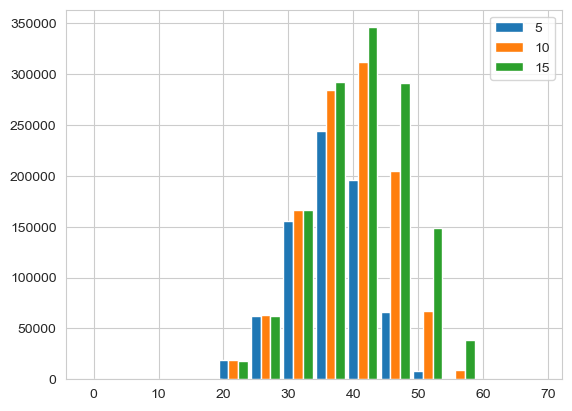

In [20]:
plt.bar(data_5['1'].index,data_5['1'].values,label='5',width=1.5)
plt.bar(data_10['1'].index+1.5,data_10['1'].values,label='10',width=1.5)
plt.bar(data_15['1'].index+3,data_15['1'].values,label='15',width=1.5)
plt.legend()
plt.show()

In [69]:
ten_data = pd.read_csv('./descriptive_stats/tenure_dist.csv')

In [73]:
years_range = ten_data['yd'].unique()
ten_data.head()

,sexo1,edad5,yd,state,wife,husband,mother,mother_5,mother_10,mother_15,...,father_15,father_state,hub_state,hub_ten_y,tenure,ten_y,wife_state,wife_ten,disc,part_time
0,1,20,2005,T,0,0,0,0,0,0,...,0,NaN,NaN,NaN,1,NaN,NaN,NaN,0,0
1,0,45,2005,P,0,1,0,0,0,0,...,0,NaN,P,29.916666,359,29.916666,P,48.0,0,0
2,1,45,2005,P,1,0,0,0,0,0,...,0,NaN,P,29.916666,48,4.000000,P,48.0,0,1
3,1,25,2005,T,0,0,0,0,0,0,...,0,NaN,P,29.916666,10,NaN,P,48.0,0,0
4,0,55,2005,P,0,0,0,0,0,0,...,0,NaN,NaN,NaN,387,NaN,NaN,NaN,0,0


In [32]:
mother_5_ten = ten_data[np.logical_and(ten_data['mother_5']==1,ten_data['wife']==1)]['ten_y'].copy()

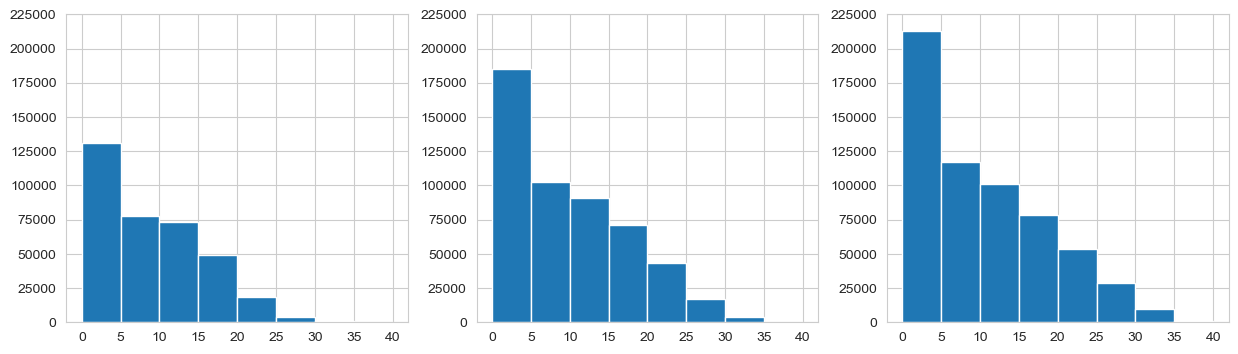

In [41]:
plt.figure(figsize=(15,4))
for i,kid_age in enumerate([5,10,15]):
    plt.subplot(131+i)
    data_slice = ten_data[np.logical_and(ten_data['mother_{}'.format(kid_age)]==1,ten_data['wife']==1)]['ten_y'].copy()
    plt.hist(data_slice.values,bins=np.arange(0,45,5))
    plt.ylim(0,225000)
    plt.xticks(np.arange(0,45,5))
plt.show()

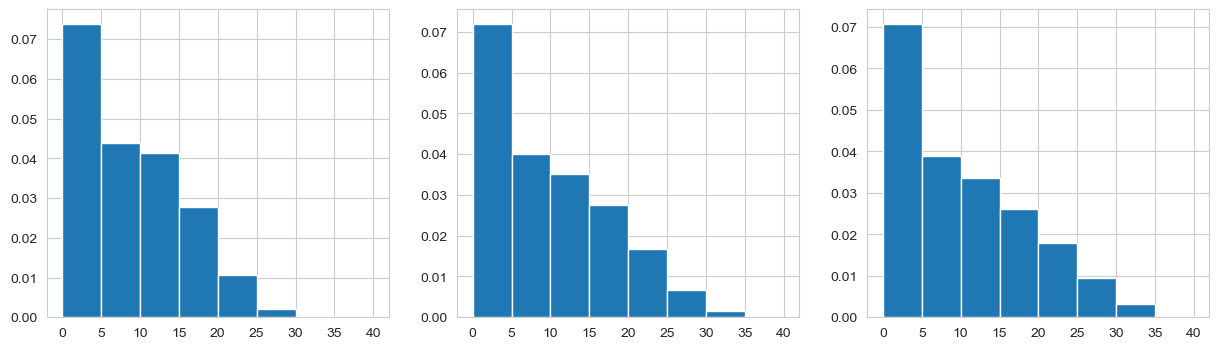

In [44]:
plt.figure(figsize=(15,4))
for i,kid_age in enumerate([5,10,15]):
    plt.subplot(131+i)
    data_slice = ten_data[np.logical_and(ten_data['mother_{}'.format(kid_age)]==1,ten_data['wife']==1)]['ten_y'].copy()
    plt.hist(data_slice.values,bins=np.arange(0,45,5),density=True)
#     plt.ylim(0,225000)
    plt.xticks(np.arange(0,45,5))
plt.show()

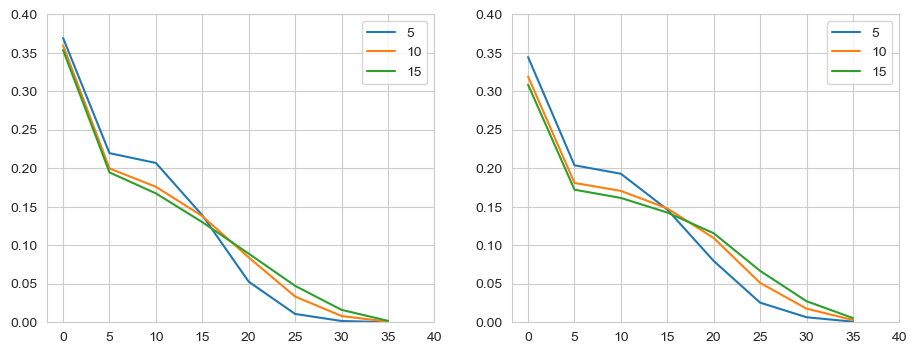

In [62]:
plt.figure(figsize=(11,4))
plt.subplot(121)
for i,kid_age in enumerate([5,10,15]):
    data_slice = ten_data[np.logical_and(ten_data['mother_{}'.format(kid_age)]==1,ten_data['wife']==1)]['ten_y'].copy()
    h, b = np.histogram(data_slice.values,bins=np.arange(0,45,5))
    plt.plot(b[:-1],h/np.sum(h),label=kid_age)
    plt.ylim(0,0.4)
plt.xticks(np.arange(0,45,5))
plt.legend()

plt.subplot(122)
for i,kid_age in enumerate([5,10,15]):
    data_slice = ten_data[np.logical_and(ten_data['father_{}'.format(kid_age)]==1,ten_data['husband']==1)]['ten_y'].copy()
    h, b = np.histogram(data_slice.values,bins=np.arange(0,45,5))
    plt.plot(b[:-1],h/np.sum(h),label=kid_age)
    plt.ylim(0,0.4)
plt.xticks(np.arange(0,45,5))
plt.legend()

plt.show()

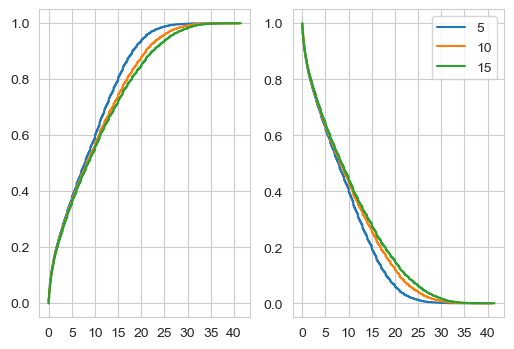

In [58]:
plt.figure(figsize=(6,4))
for i,kid_age in enumerate([5,10,15]):
    data_slice = ten_data[np.logical_and(ten_data['mother_{}'.format(kid_age)]==1,ten_data['wife']==1)]['ten_y'].copy()
    x = np.sort(data_slice)
    y = np.arange(len(x))/float(len(x))
    plt.subplot(121)
    plt.plot(x, y,label=kid_age)
#     plt.ylim(0,225000)
    plt.xticks(np.arange(0,45,5))
    plt.subplot(122)
    plt.plot(x, 1-y,label=kid_age)
#     plt.ylim(0,225000)
    plt.xticks(np.arange(0,45,5))
plt.legend()
plt.show()

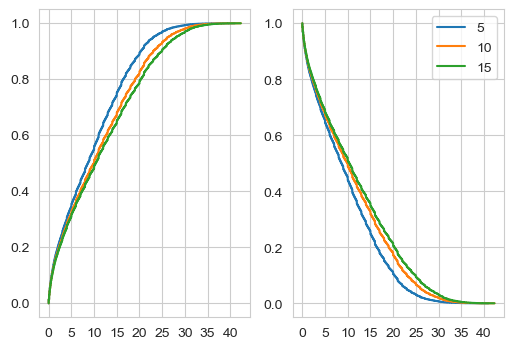

In [59]:
plt.figure(figsize=(6,4))
for i,kid_age in enumerate([5,10,15]):
    data_slice = ten_data[np.logical_and(ten_data['father_{}'.format(kid_age)]==1,ten_data['husband']==1)]['ten_y'].copy()
    x = np.sort(data_slice)
    y = np.arange(len(x))/float(len(x))
    plt.subplot(121)
    plt.plot(x, y,label=kid_age)
#     plt.ylim(0,225000)
    plt.xticks(np.arange(0,45,5))
    plt.subplot(122)
    plt.plot(x, 1-y,label=kid_age)
#     plt.ylim(0,225000)
    plt.xticks(np.arange(0,45,5))
plt.legend()
plt.show()

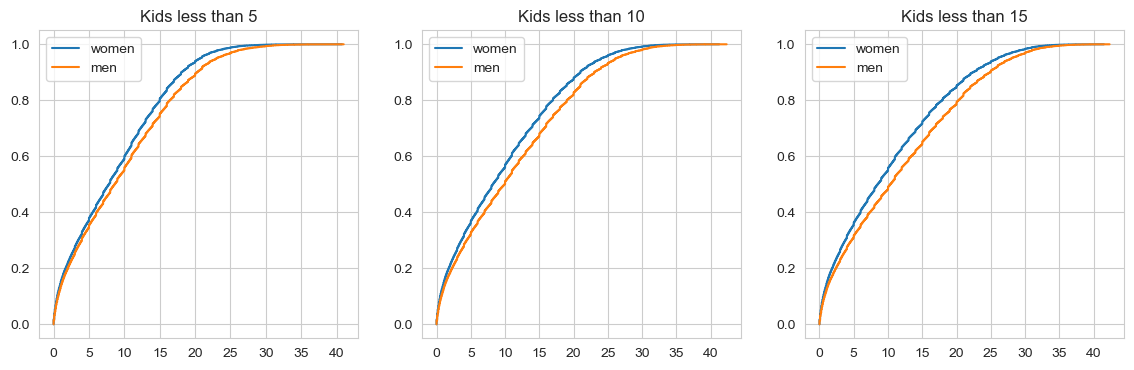

In [65]:
plt.figure(figsize=(14,4))
for i,kid_age in enumerate([5,10,15]):
    plt.subplot(131+i)
    plt.title('Kids less than {}'.format(kid_age))
    data_slice = ten_data[np.logical_and(ten_data['mother_{}'.format(kid_age)]==1,ten_data['wife']==1)]['ten_y'].copy()
    x = np.sort(data_slice)
    y = np.arange(len(x))/float(len(x))
    plt.plot(x, y,label='women')
    
    data_slice = ten_data[np.logical_and(ten_data['father_{}'.format(kid_age)]==1,ten_data['husband']==1)]['ten_y'].copy()
    x = np.sort(data_slice)
    y = np.arange(len(x))/float(len(x))
    plt.plot(x, y,label='men')
    plt.xticks(np.arange(0,45,5))
    plt.legend()
plt.show()

In [43]:

plt.figure(figsize=(6,4))
for i,kid_age in enumerate([5,10,15]):
    data_mothers = ten_data[np.logical_and(ten_data['mother_{}'.format(kid_age)]==1,ten_data['wife']==1)]['ten_y'].copy()
    data_mothers = 
    x = np.sort(data_slice)
    y = np.arange(len(x))/float(len(x))
    plt.subplot(121)
    plt.plot(x, y,label=kid_age)
#     plt.ylim(0,225000)
    plt.xticks(np.arange(0,45,5))
    plt.subplot(122)
    plt.plot(x, 1-y,label=kid_age)
#     plt.ylim(0,225000)
    plt.xticks(np.arange(0,45,5))
plt.legend()
plt.show()


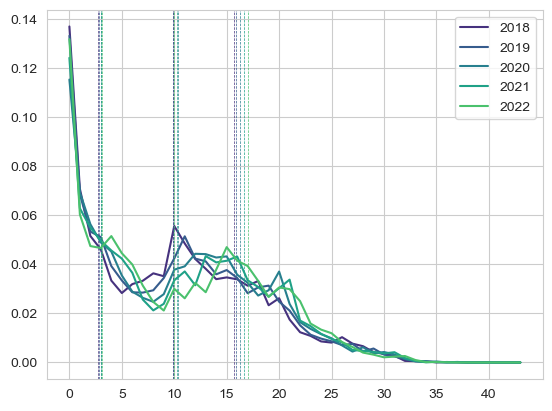

In [103]:
kid_age = 10
cs = sn.color_palette('viridis')
sn.set_palette(cs)
data_mothers = ten_data[np.logical_and(ten_data['mother_{}'.format(kid_age)]==1,ten_data['wife']==1)].copy()
for i,year in enumerate(years_range[-5:]):
    dta = data_mothers[data_mothers['yd']==year]['ten_y'].copy()
    h, b = np.histogram(dta.values,bins=np.arange(0,45,1))
    plt.plot(b[:-1],h/np.sum(h),label=year)
    plt.axvline(dta.describe()['25%'],lw=0.5,ls='--',c=cs[i])
    plt.axvline(dta.describe()['50%'],lw=0.5,ls='--',c=cs[i])
    plt.axvline(dta.describe()['75%'],lw=0.5,ls='--',c=cs[i])
plt.legend()
plt.xticks(np.arange(0,45,5))
plt.show()

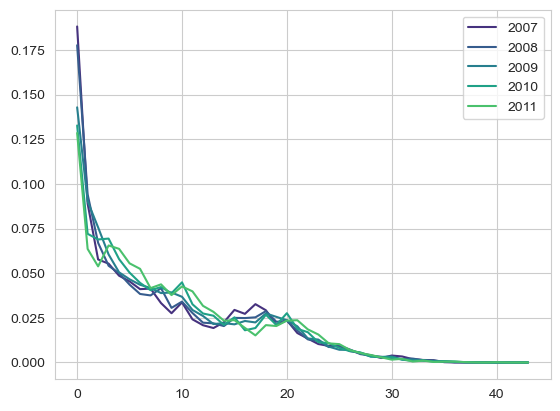

In [92]:
kid_age = 10
sn.set_palette('viridis')
data_mothers = ten_data[np.logical_and(ten_data['mother_{}'.format(kid_age)]==1,ten_data['wife']==1)].copy()
for year in years_range[2:7]:
    dta = data_mothers[data_mothers['yd']==year]['ten_y'].copy()
    h, b = np.histogram(dta.values,bins=np.arange(0,45,1))
    plt.plot(b[:-1],h/np.sum(h),label=year)
plt.legend()
plt.show()

In [ ]:
kid_age = 10
sn.set_palette('viridis')
data_mothers = ten_data[np.logical_and(ten_data['mother_{}'.format(kid_age)]==1,ten_data['wife']==1)].copy()
for year in years_range[-5:]:
    dta = data_mothers[np.logical

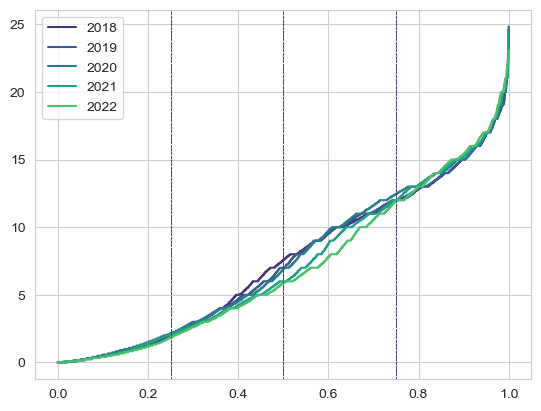

In [89]:
kid_age = 10
sn.set_palette('viridis')
data_mothers = ten_data[np.logical_and(ten_data['mother_{}'.format(kid_age)]==1,ten_data['wife']==1)].copy()
for year in years_range[-5:]:
    dta = data_mothers[np.logical_and(data_mothers['yd']==year,
                                      np.logical_and(data_mothers['edad5']>=30,data_mothers['edad5']<=35))]['ten_y'].copy()
    x = np.sort(dta)
    y = np.arange(len(x))/float(len(x))
    plt.plot(y,x,label=year)
    plt.axvline(0.25,lw=0.5,ls='--')
    plt.axvline(0.5,lw=0.5,ls='--')
    plt.axvline(0.75,lw=0.5,ls='--')
plt.legend()
plt.show()

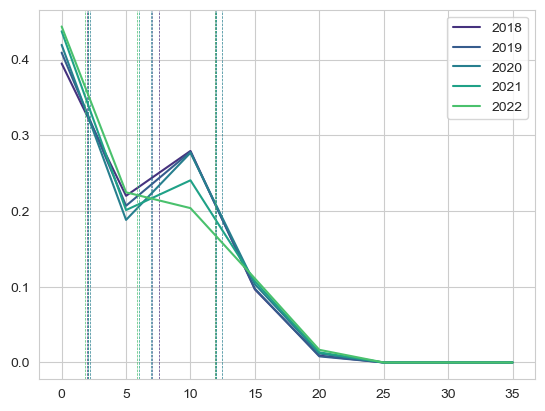

In [106]:
kid_age = 10
cs = sn.color_palette('viridis')
sn.set_palette(cs)
sn.set_palette('viridis')
data_mothers = ten_data[np.logical_and(ten_data['mother_{}'.format(kid_age)]==1,ten_data['wife']==1)].copy()
for i,year in enumerate(years_range[-5:]):
    dta = data_mothers[np.logical_and(data_mothers['yd']==year,
                                      np.logical_and(data_mothers['edad5']>=30,data_mothers['edad5']<=35))]['ten_y'].copy()
    h, b = np.histogram(dta.values,bins=np.arange(0,45,5))
    plt.plot(b[:-1],h/np.sum(h),label=year)
    plt.axvline(dta.describe()['25%'],lw=0.5,ls='--',c=cs[i])
    plt.axvline(dta.describe()['50%'],lw=0.5,ls='--',c=cs[i])
    plt.axvline(dta.describe()['75%'],lw=0.5,ls='--',c=cs[i])
plt.legend()
plt.show()

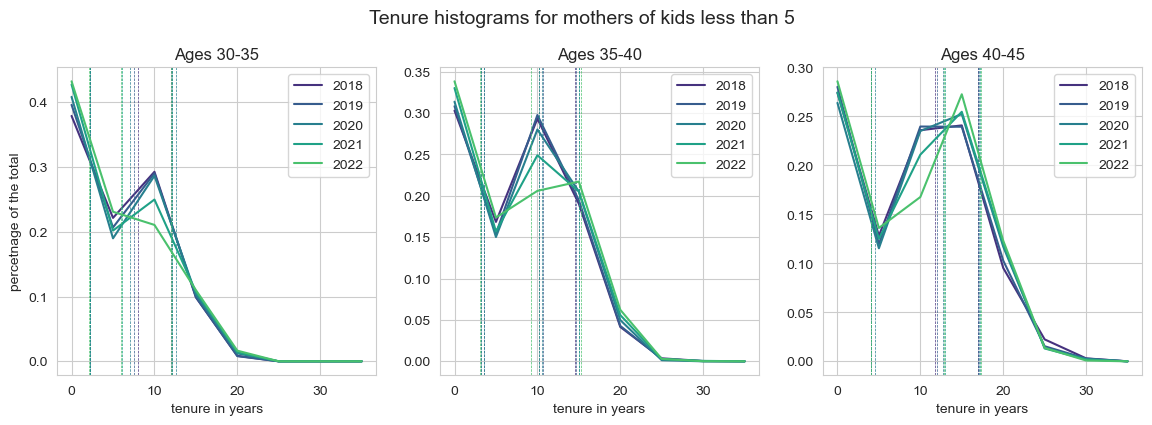

In [117]:
kid_age = 5
cs = sn.color_palette('viridis')
sn.set_palette(cs)

plt.figure(figsize=(14,4))
plt.suptitle('Tenure histograms for mothers of kids less than {}'.format(kid_age),y=1.025,fontsize=14)
data_mothers = ten_data[np.logical_and(ten_data['mother_{}'.format(kid_age)]==1,ten_data['wife']==1)].copy()
for j,age in enumerate([30,35,40]):
    plt.subplot(131+j)
    plt.title('Ages {}-{}'.format(age,age+5))
    for i,year in enumerate(years_range[-5:]):
        dta = data_mothers[np.logical_and(data_mothers['yd']==year,
                                          np.logical_and(data_mothers['edad5']>=age,
                                                         data_mothers['edad5']<age+10))]['ten_y'].copy()
        h, b = np.histogram(dta.values,bins=np.arange(0,45,5))
        plt.plot(b[:-1],h/np.sum(h),label=year)
        plt.axvline(dta.describe()['25%'],lw=0.5,ls='--',c=cs[i])
        plt.axvline(dta.describe()['50%'],lw=0.5,ls='--',c=cs[i])
        plt.axvline(dta.describe()['75%'],lw=0.5,ls='--',c=cs[i])
    plt.legend()
    plt.xlabel('tenure in years')
    if j==0:
        plt.ylabel('percetnage of the total')
plt.show()

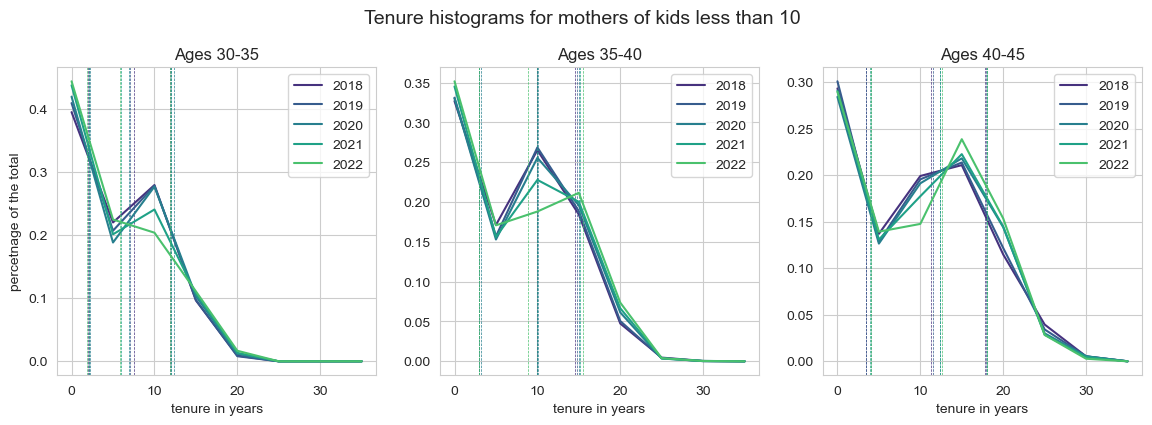

In [116]:
kid_age = 10
cs = sn.color_palette('viridis')
sn.set_palette(cs)

plt.figure(figsize=(14,4))
plt.suptitle('Tenure histograms for mothers of kids less than {}'.format(kid_age),y=1.025,fontsize=14)
data_mothers = ten_data[np.logical_and(ten_data['mother_{}'.format(kid_age)]==1,ten_data['wife']==1)].copy()
for j,age in enumerate([30,35,40]):
    plt.subplot(131+j)
    plt.title('Ages {}-{}'.format(age,age+5))
    for i,year in enumerate(years_range[-5:]):
        dta = data_mothers[np.logical_and(data_mothers['yd']==year,
                                          np.logical_and(data_mothers['edad5']>=age,
                                                         data_mothers['edad5']<age+10))]['ten_y'].copy()
        h, b = np.histogram(dta.values,bins=np.arange(0,45,5))
        plt.plot(b[:-1],h/np.sum(h),label=year)
        plt.axvline(dta.describe()['25%'],lw=0.5,ls='--',c=cs[i])
        plt.axvline(dta.describe()['50%'],lw=0.5,ls='--',c=cs[i])
        plt.axvline(dta.describe()['75%'],lw=0.5,ls='--',c=cs[i])
    plt.legend()
    plt.xlabel('tenure in years')
    if j==0:
        plt.ylabel('percetnage of the total')
plt.show()

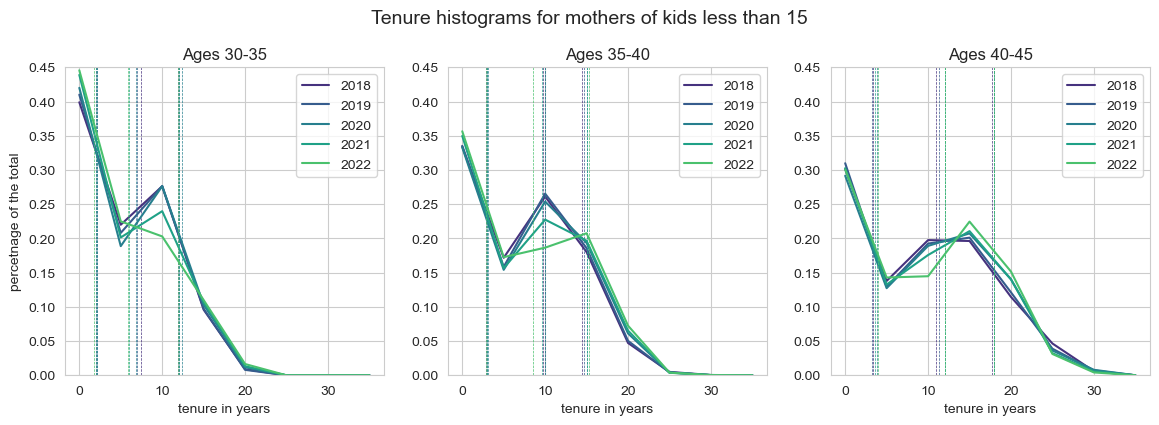

In [123]:
kid_age = 15
cs = sn.color_palette('viridis')
sn.set_palette(cs)

plt.figure(figsize=(14,4))
plt.suptitle('Tenure histograms for mothers of kids less than {}'.format(kid_age),y=1.025,fontsize=14)
data_mothers = ten_data[np.logical_and(ten_data['mother_{}'.format(kid_age)]==1,ten_data['wife']==1)].copy()
for j,age in enumerate([30,35,40]):
    plt.subplot(131+j)
    plt.title('Ages {}-{}'.format(age,age+5))
    for i,year in enumerate(years_range[-5:]):
        dta = data_mothers[np.logical_and(data_mothers['yd']==year,
                                          np.logical_and(data_mothers['edad5']>=age,
                                                         data_mothers['edad5']<age+10))]['ten_y'].copy()
        h, b = np.histogram(dta.values,bins=np.arange(0,45,5))
        plt.plot(b[:-1],h/np.sum(h),label=year)
        plt.axvline(dta.describe()['25%'],lw=0.5,ls='--',c=cs[i])
        plt.axvline(dta.describe()['50%'],lw=0.5,ls='--',c=cs[i])
        plt.axvline(dta.describe()['75%'],lw=0.5,ls='--',c=cs[i])
    plt.ylim(0,0.45)
    plt.legend()
    plt.xlabel('tenure in years')
    if j==0:
        plt.ylabel('percetnage of the total')
plt.show()

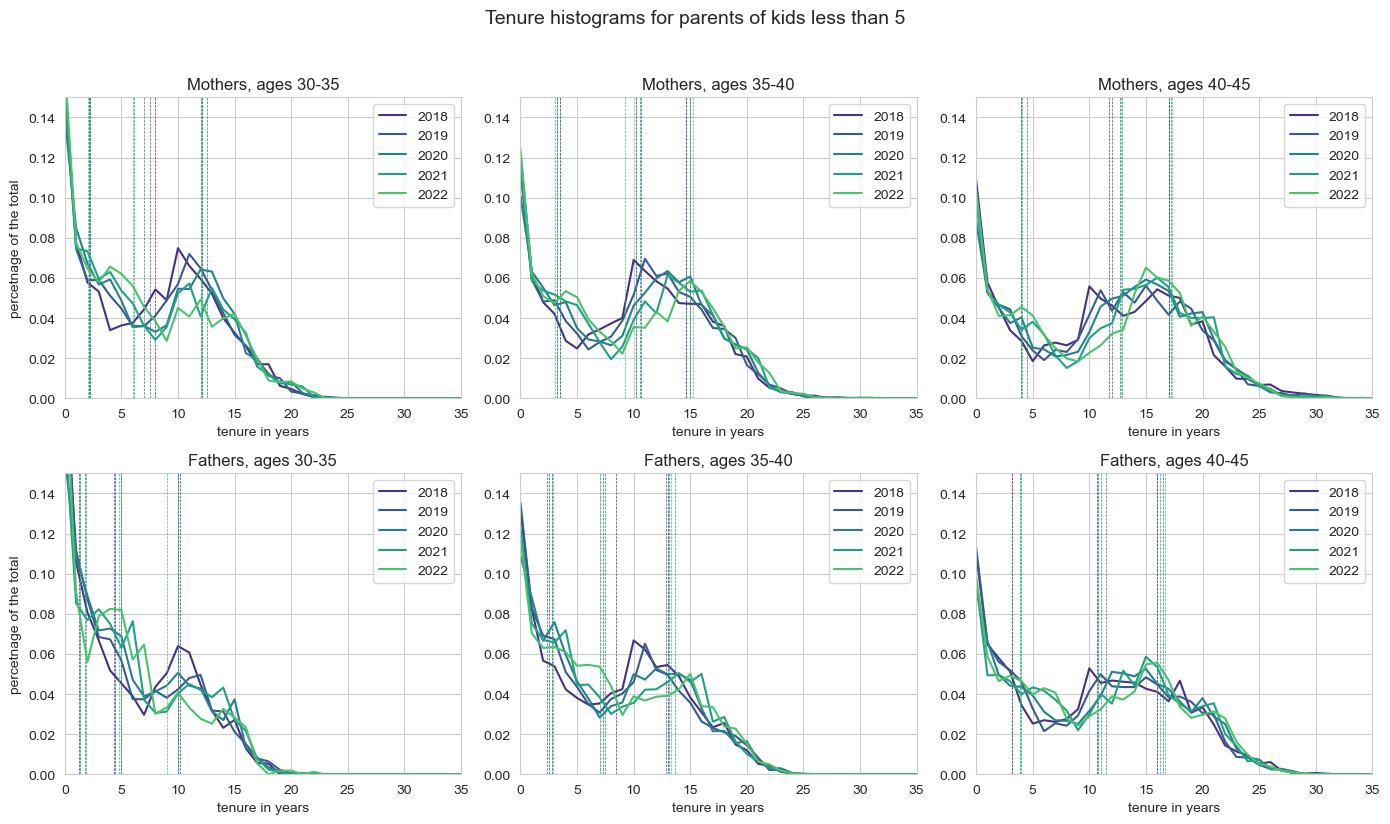

In [136]:
kid_age = 5
cs = sn.color_palette('viridis')
sn.set_palette(cs)

plt.figure(figsize=(14,8))
plt.suptitle('Tenure histograms for parents of kids less than {}'.format(kid_age),y=1.025,fontsize=14)
data_fathers = ten_data[np.logical_and(ten_data['father_{}'.format(kid_age)]==1,ten_data['husband']==1)].copy()
data_mothers = ten_data[np.logical_and(ten_data['mother_{}'.format(kid_age)]==1,ten_data['wife']==1)].copy()
for j,age in enumerate([30,35,40]):
    plt.subplot(231+j)
    plt.title('Mothers, ages {}-{}'.format(age,age+5))
    for i,year in enumerate(years_range[-5:]):
        dta = data_mothers[np.logical_and(data_mothers['yd']==year,
                                          np.logical_and(data_mothers['edad5']>=age,
                                                         data_mothers['edad5']<age+10))]['ten_y'].copy()
        h, b = np.histogram(dta.values,bins=np.arange(0,45,1))
        plt.plot(b[:-1],h/np.sum(h),label=year)
        plt.axvline(dta.describe()['25%'],lw=0.5,ls='--',c=cs[i])
        plt.axvline(dta.describe()['50%'],lw=0.5,ls='--',c=cs[i])
        plt.axvline(dta.describe()['75%'],lw=0.5,ls='--',c=cs[i])
    plt.ylim(0,0.15)
    plt.legend()
    plt.xlabel('tenure in years')
    if j==0:
        plt.ylabel('percetnage of the total')
    plt.xlim(0,35)
for j,age in enumerate([30,35,40]):
    plt.subplot(234+j)
    plt.title('Fathers, ages {}-{}'.format(age,age+5))
    for i,year in enumerate(years_range[-5:]):
        dta = data_fathers[np.logical_and(data_fathers['yd']==year,
                                          np.logical_and(data_fathers['edad5']>=age,
                                                         data_fathers['edad5']<age+5))]['ten_y'].copy()
        h, b = np.histogram(dta.values,bins=np.arange(0,45,1))
        plt.plot(b[:-1],h/np.sum(h),label=year)
        plt.axvline(dta.describe()['25%'],lw=0.5,ls='--',c=cs[i])
        plt.axvline(dta.describe()['50%'],lw=0.5,ls='--',c=cs[i])
        plt.axvline(dta.describe()['75%'],lw=0.5,ls='--',c=cs[i])
    plt.ylim(0,0.15)
    plt.xlim(0,35)
    plt.legend()
    plt.xlabel('tenure in years')
    if j==0:
        plt.ylabel('percetnage of the total')
plt.tight_layout()
plt.show()

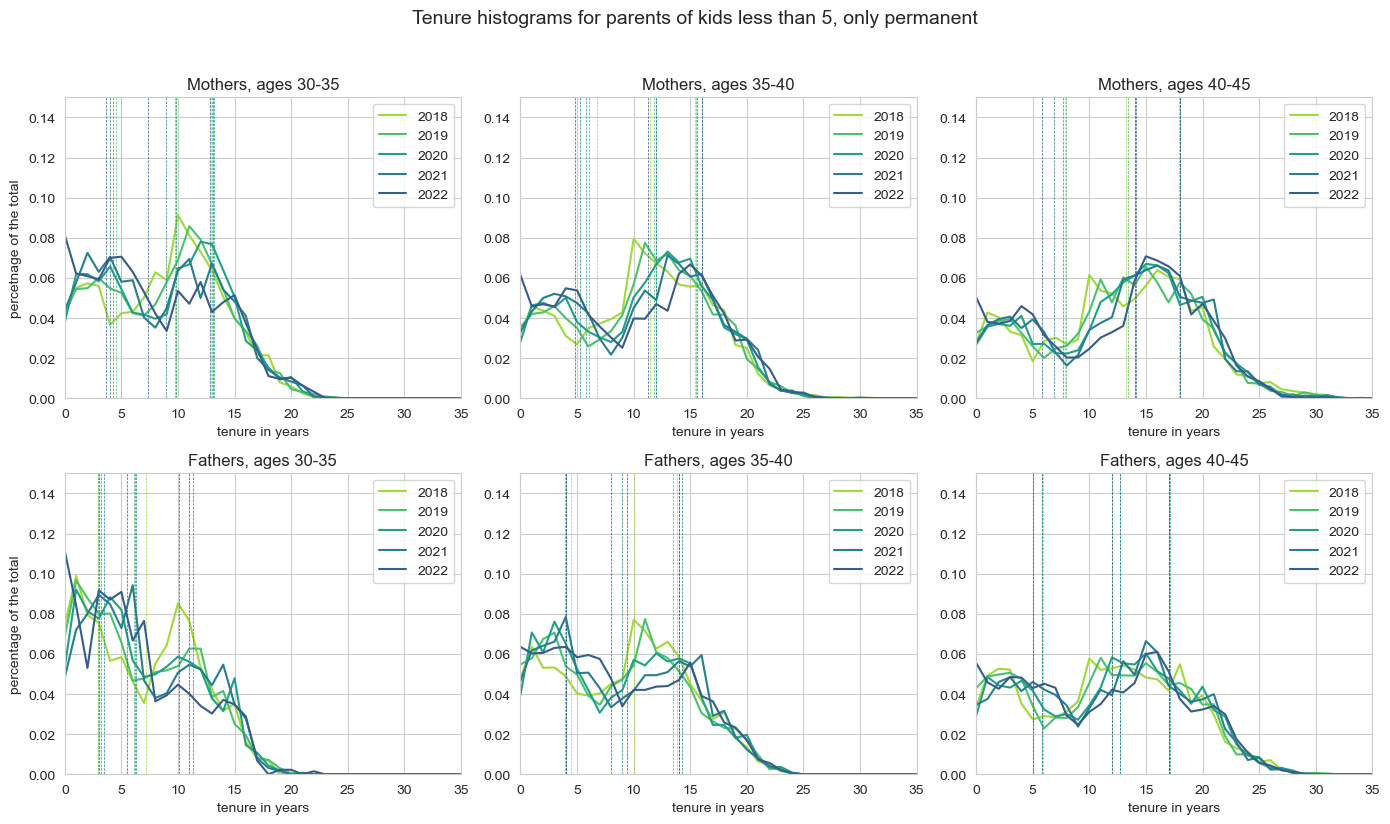

In [140]:
kid_age = 5
cs = sn.color_palette('viridis_r',)
sn.set_palette(cs)

plt.figure(figsize=(14,8))
plt.suptitle('Tenure histograms for parents of kids less than {}, only permanent'.format(kid_age),y=1.025,fontsize=14)
data_fathers = ten_data[np.logical_and(ten_data['father_{}'.format(kid_age)]==1,ten_data['husband']==1)].copy()
data_mothers = ten_data[np.logical_and(ten_data['mother_{}'.format(kid_age)]==1,ten_data['wife']==1)].copy()
for j,age in enumerate([30,35,40]):
    plt.subplot(231+j)
    plt.title('Mothers, ages {}-{}'.format(age,age+5))
    for i,year in enumerate(years_range[-5:]):
        dta = data_mothers[np.logical_and(data_mothers['yd']==year,np.logical_and(data_mothers['state']=='P',
                                          np.logical_and(data_mothers['edad5']>=age,
                                                         data_mothers['edad5']<age+10)))]['ten_y'].copy()
        h, b = np.histogram(dta.values,bins=np.arange(0,45,1))
        plt.plot(b[:-1],h/np.sum(h),label=year)
        plt.axvline(dta.describe()['25%'],lw=0.5,ls='--',c=cs[i])
        plt.axvline(dta.describe()['50%'],lw=0.5,ls='--',c=cs[i])
        plt.axvline(dta.describe()['75%'],lw=0.5,ls='--',c=cs[i])
    plt.ylim(0,0.15)
    plt.legend()
    plt.xlabel('tenure in years')
    if j==0:
        plt.ylabel('percetnage of the total')
    plt.xlim(0,35)
for j,age in enumerate([30,35,40]):
    plt.subplot(234+j)
    plt.title('Fathers, ages {}-{}'.format(age,age+5))
    for i,year in enumerate(years_range[-5:]):
        dta = data_fathers[np.logical_and(data_fathers['yd']==year,np.logical_and(data_fathers['state']=='P',
                                          np.logical_and(data_fathers['edad5']>=age,
                                                         data_fathers['edad5']<age+5)))]['ten_y'].copy()
        h, b = np.histogram(dta.values,bins=np.arange(0,45,1))
        plt.plot(b[:-1],h/np.sum(h),label=year)
        plt.axvline(dta.describe()['25%'],lw=0.5,ls='--',c=cs[i])
        plt.axvline(dta.describe()['50%'],lw=0.5,ls='--',c=cs[i])
        plt.axvline(dta.describe()['75%'],lw=0.5,ls='--',c=cs[i])
    plt.ylim(0,0.15)
    plt.xlim(0,35)
    plt.legend()
    plt.xlabel('tenure in years')
    if j==0:
        plt.ylabel('percentage of the total')
plt.tight_layout()
plt.show()

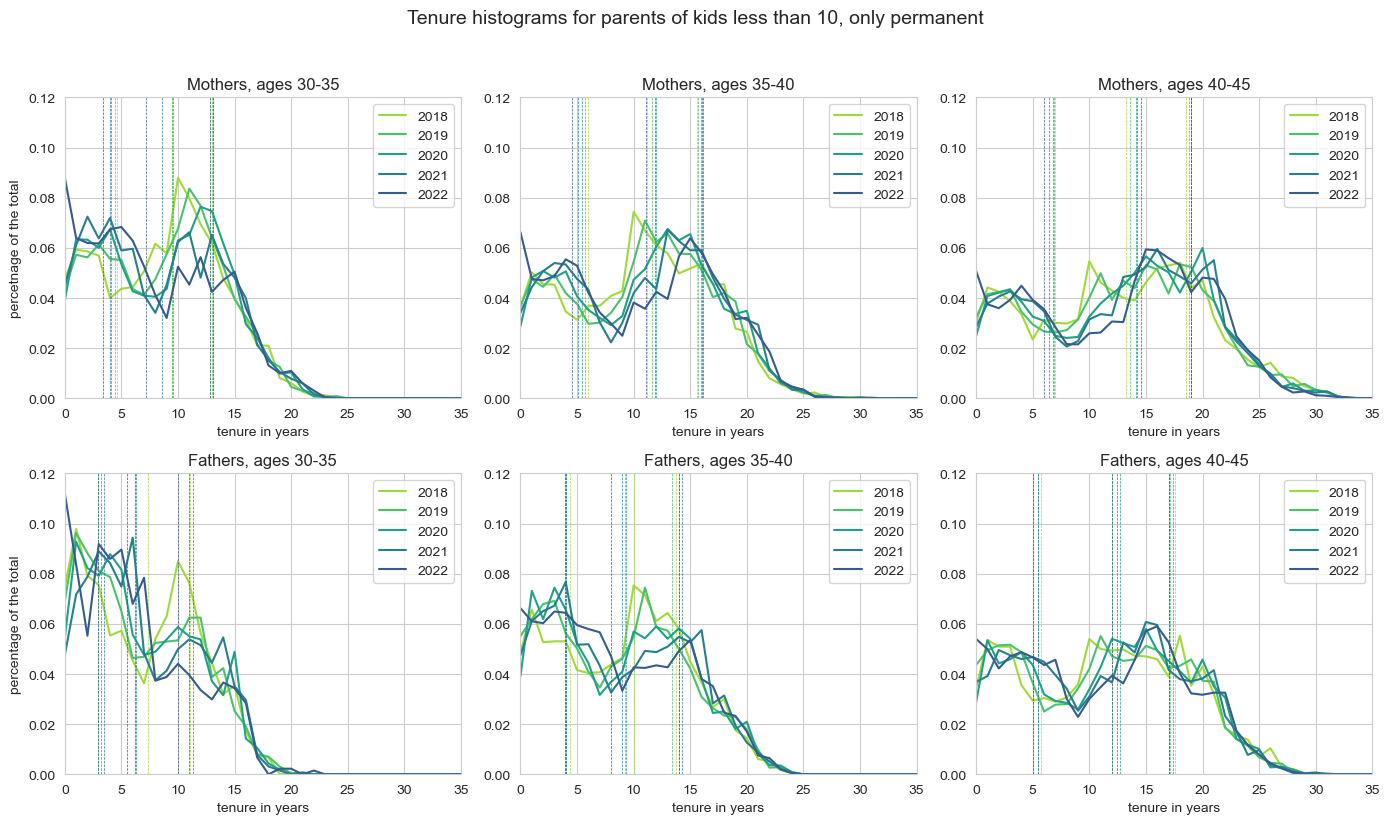

In [142]:
kid_age = 10
cs = sn.color_palette('viridis_r',)
sn.set_palette(cs)

plt.figure(figsize=(14,8))
plt.suptitle('Tenure histograms for parents of kids less than {}, only permanent'.format(kid_age),y=1.025,fontsize=14)
data_fathers = ten_data[np.logical_and(ten_data['father_{}'.format(kid_age)]==1,ten_data['husband']==1)].copy()
data_mothers = ten_data[np.logical_and(ten_data['mother_{}'.format(kid_age)]==1,ten_data['wife']==1)].copy()
for j,age in enumerate([30,35,40]):
    plt.subplot(231+j)
    plt.title('Mothers, ages {}-{}'.format(age,age+5))
    for i,year in enumerate(years_range[-5:]):
        dta = data_mothers[np.logical_and(data_mothers['yd']==year,np.logical_and(data_mothers['state']=='P',
                                          np.logical_and(data_mothers['edad5']>=age,
                                                         data_mothers['edad5']<age+10)))]['ten_y'].copy()
        h, b = np.histogram(dta.values,bins=np.arange(0,45,1))
        plt.plot(b[:-1],h/np.sum(h),label=year)
        plt.axvline(dta.describe()['25%'],lw=0.5,ls='--',c=cs[i])
        plt.axvline(dta.describe()['50%'],lw=0.5,ls='--',c=cs[i])
        plt.axvline(dta.describe()['75%'],lw=0.5,ls='--',c=cs[i])
    plt.ylim(0,0.12)
    plt.legend()
    plt.xlabel('tenure in years')
    if j==0:
        plt.ylabel('percetnage of the total')
    plt.xlim(0,35)
for j,age in enumerate([30,35,40]):
    plt.subplot(234+j)
    plt.title('Fathers, ages {}-{}'.format(age,age+5))
    for i,year in enumerate(years_range[-5:]):
        dta = data_fathers[np.logical_and(data_fathers['yd']==year,np.logical_and(data_fathers['state']=='P',
                                          np.logical_and(data_fathers['edad5']>=age,
                                                         data_fathers['edad5']<age+5)))]['ten_y'].copy()
        h, b = np.histogram(dta.values,bins=np.arange(0,45,1))
        plt.plot(b[:-1],h/np.sum(h),label=year)
        plt.axvline(dta.describe()['25%'],lw=0.5,ls='--',c=cs[i])
        plt.axvline(dta.describe()['50%'],lw=0.5,ls='--',c=cs[i])
        plt.axvline(dta.describe()['75%'],lw=0.5,ls='--',c=cs[i])
    plt.ylim(0,0.12)
    plt.xlim(0,35)
    plt.legend()
    plt.xlabel('tenure in years')
    if j==0:
        plt.ylabel('percentage of the total')
plt.tight_layout()
plt.show()

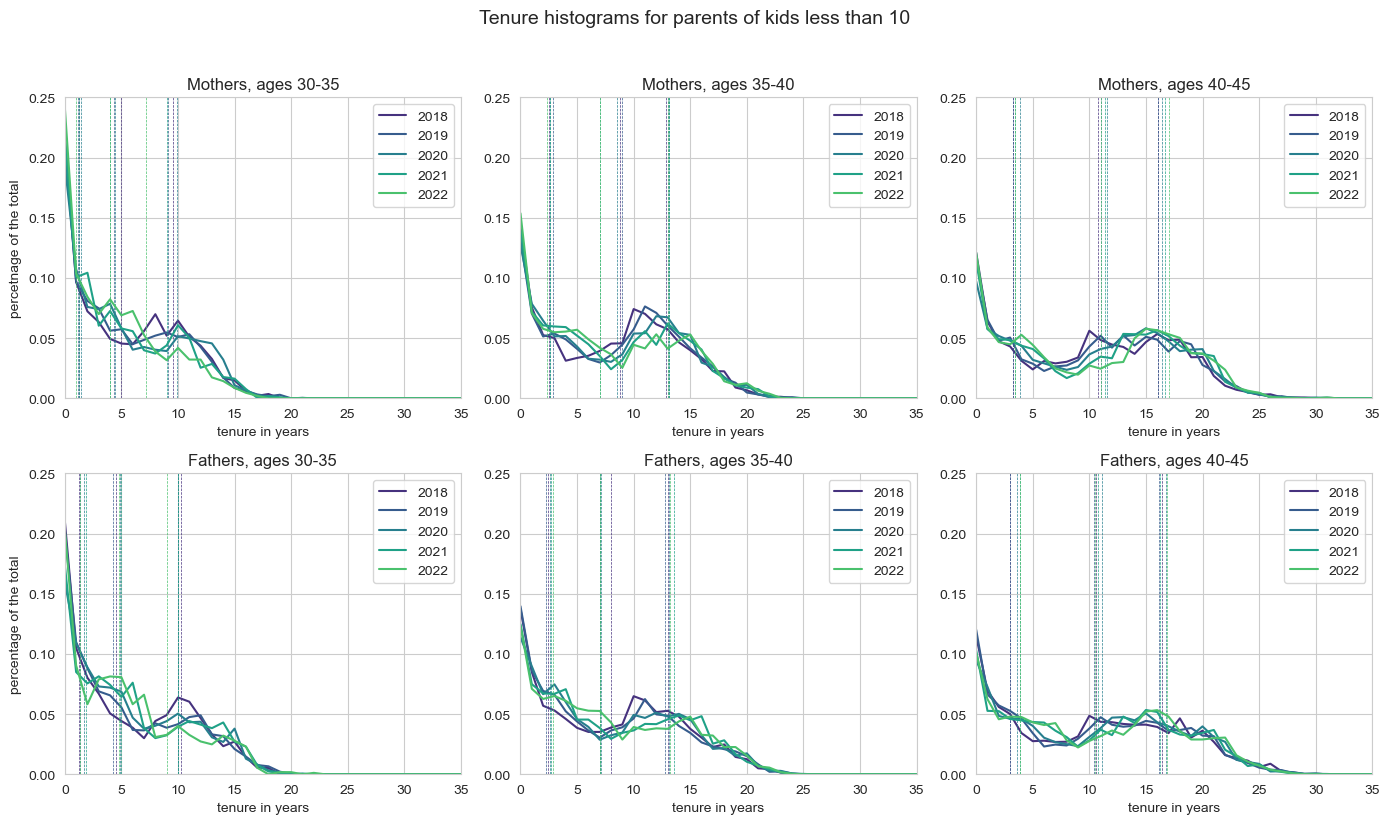

In [151]:
kid_age = 10
cs = sn.color_palette('viridis')
sn.set_palette(cs)

plt.figure(figsize=(14,8))
plt.suptitle('Tenure histograms for parents of kids less than {}'.format(kid_age),y=1.025,fontsize=14)
data_fathers = ten_data[np.logical_and(ten_data['father_{}'.format(kid_age)]==1,ten_data['husband']==1)].copy()
data_mothers = ten_data[np.logical_and(ten_data['mother_{}'.format(kid_age)]==1,ten_data['wife']==1)].copy()
for j,age in enumerate([30,35,40]):
    plt.subplot(231+j)
    plt.title('Mothers, ages {}-{}'.format(age,age+5))
    for i,year in enumerate(years_range[-5:]):
        dta = data_mothers[np.logical_and(data_mothers['yd']==year,
                                          np.logical_and(data_mothers['edad5']>=age,
                                                         data_mothers['edad5']<age+5))]['ten_y'].copy()
        h, b = np.histogram(dta.values,bins=np.arange(0,45,1))
        plt.plot(b[:-1],h/np.sum(h),label=year)
        plt.axvline(dta.describe()['25%'],lw=0.5,ls='--',c=cs[i])
        plt.axvline(dta.describe()['50%'],lw=0.5,ls='--',c=cs[i])
        plt.axvline(dta.describe()['75%'],lw=0.5,ls='--',c=cs[i])
    plt.ylim(0,0.25)
    plt.xlim(0,35)
    plt.legend()
    plt.xlabel('tenure in years')
    if j==0:
        plt.ylabel('percetnage of the total')
for j,age in enumerate([30,35,40]):
    plt.subplot(234+j)
    plt.title('Fathers, ages {}-{}'.format(age,age+5))
    for i,year in enumerate(years_range[-5:]):
        dta = data_fathers[np.logical_and(data_fathers['yd']==year,
                                          np.logical_and(data_fathers['edad5']>=age,
                                                         data_fathers['edad5']<age+5))]['ten_y'].copy()
        h, b = np.histogram(dta.values,bins=np.arange(0,45,1))
        plt.plot(b[:-1],h/np.sum(h),label=year)
        plt.axvline(dta.describe()['25%'],lw=0.5,ls='--',c=cs[i])
        plt.axvline(dta.describe()['50%'],lw=0.5,ls='--',c=cs[i])
        plt.axvline(dta.describe()['75%'],lw=0.5,ls='--',c=cs[i])
    plt.ylim(0,0.25)
    plt.xlim(0,35)
    plt.legend()
    plt.xlabel('tenure in years')
    if j==0:
        plt.ylabel('percentage of the total')
plt.tight_layout()
plt.show()

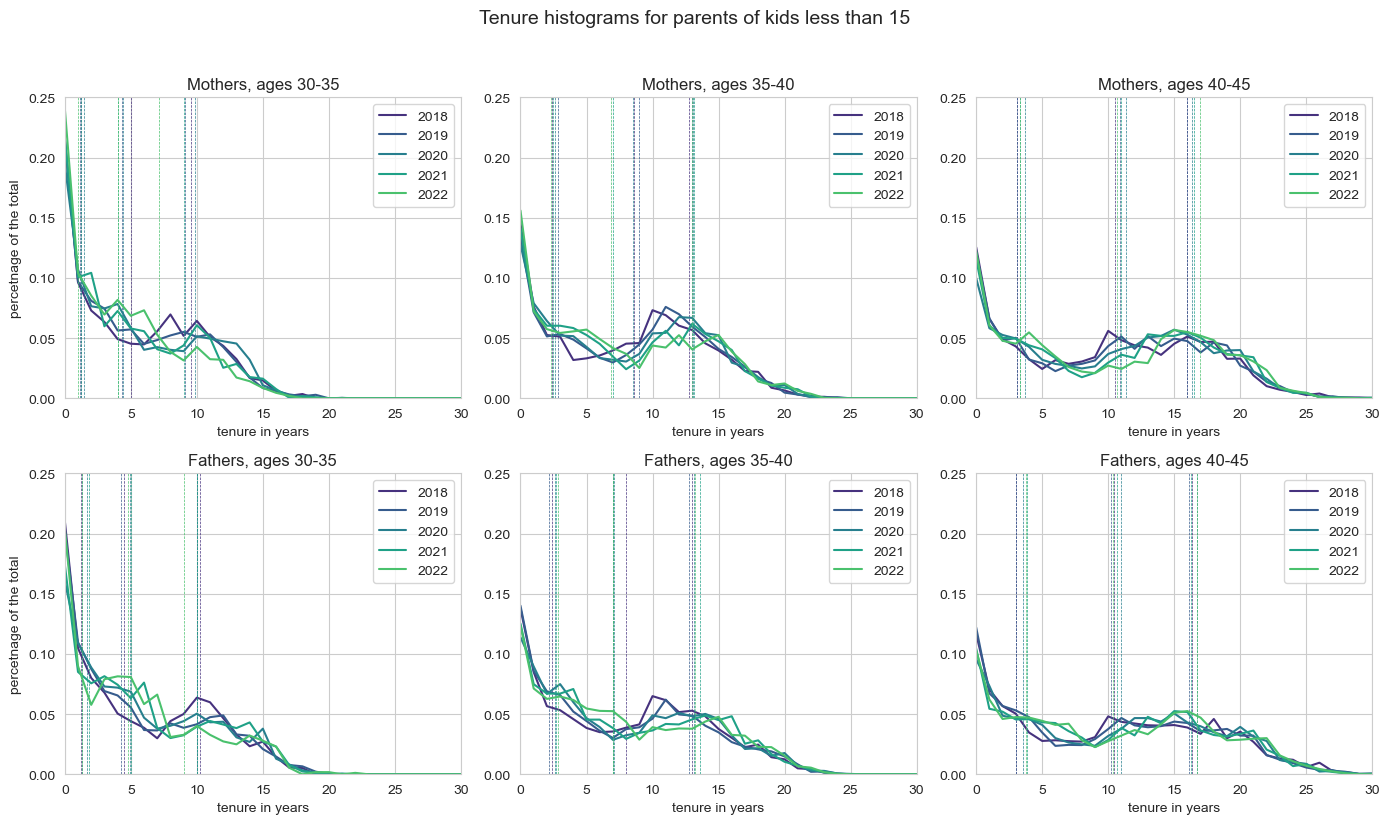

In [154]:
kid_age = 15
cs = sn.color_palette('viridis')
sn.set_palette(cs)

plt.figure(figsize=(14,8))
plt.suptitle('Tenure histograms for parents of kids less than {}'.format(kid_age),y=1.025,fontsize=14)
data_fathers = ten_data[np.logical_and(ten_data['father_{}'.format(kid_age)]==1,ten_data['husband']==1)].copy()
data_mothers = ten_data[np.logical_and(ten_data['mother_{}'.format(kid_age)]==1,ten_data['wife']==1)].copy()
for j,age in enumerate([30,35,40]):
    plt.subplot(231+j)
    plt.title('Mothers, ages {}-{}'.format(age,age+5))
    for i,year in enumerate(years_range[-5:]):
        dta = data_mothers[np.logical_and(data_mothers['yd']==year,
                                          np.logical_and(data_mothers['edad5']>=age,
                                                         data_mothers['edad5']<age+5))]['ten_y'].copy()
        h, b = np.histogram(dta.values,bins=np.arange(0,45,1))
        plt.plot(b[:-1],h/np.sum(h),label=year)
        plt.axvline(dta.describe()['25%'],lw=0.5,ls='--',c=cs[i])
        plt.axvline(dta.describe()['50%'],lw=0.5,ls='--',c=cs[i])
        plt.axvline(dta.describe()['75%'],lw=0.5,ls='--',c=cs[i])
    plt.ylim(0,0.25)
    plt.xlim(0,30)
    plt.legend()
    plt.xlabel('tenure in years')
    if j==0:
        plt.ylabel('percetnage of the total')
for j,age in enumerate([30,35,40]):
    plt.subplot(234+j)
    plt.title('Fathers, ages {}-{}'.format(age,age+5))
    for i,year in enumerate(years_range[-5:]):
        dta = data_fathers[np.logical_and(data_fathers['yd']==year,
                                          np.logical_and(data_fathers['edad5']>=age,
                                                         data_fathers['edad5']<age+5))]['ten_y'].copy()
        h, b = np.histogram(dta.values,bins=np.arange(0,45,1))
        plt.plot(b[:-1],h/np.sum(h),label=year)
        plt.axvline(dta.describe()['25%'],lw=0.5,ls='--',c=cs[i])
        plt.axvline(dta.describe()['50%'],lw=0.5,ls='--',c=cs[i])
        plt.axvline(dta.describe()['75%'],lw=0.5,ls='--',c=cs[i])
    plt.ylim(0,0.25)
    plt.xlim(0,30)
    plt.legend()
    plt.xlabel('tenure in years')
    if j==0:
        plt.ylabel('percetnage of the total')
plt.tight_layout()
plt.show()

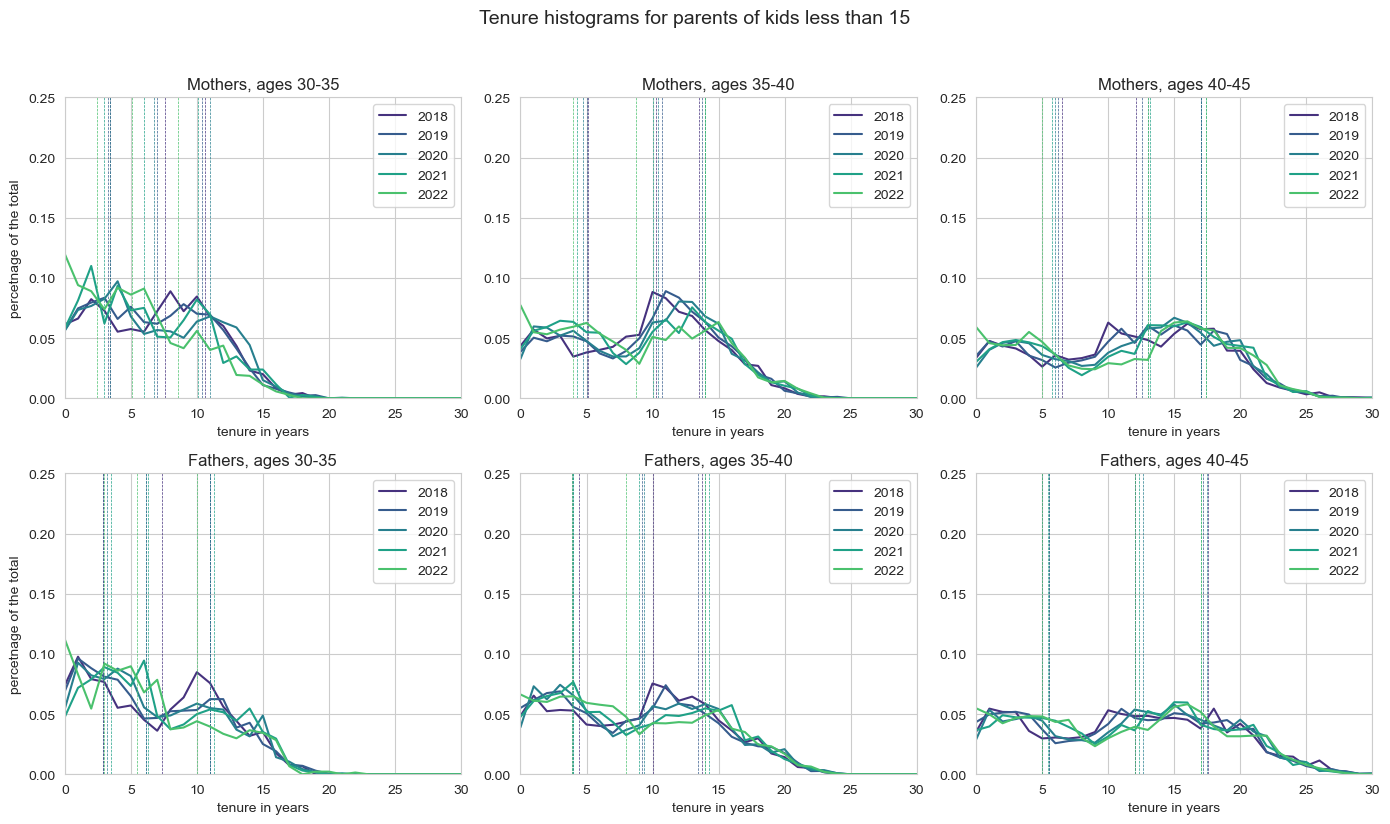

In [155]:
kid_age = 15
cs = sn.color_palette('viridis')
sn.set_palette(cs)

plt.figure(figsize=(14,8))
plt.suptitle('Tenure histograms for parents of kids less than {}'.format(kid_age),y=1.025,fontsize=14)
data_fathers = ten_data[np.logical_and(ten_data['father_{}'.format(kid_age)]==1,ten_data['husband']==1)].copy()
data_mothers = ten_data[np.logical_and(ten_data['mother_{}'.format(kid_age)]==1,ten_data['wife']==1)].copy()
for j,age in enumerate([30,35,40]):
    plt.subplot(231+j)
    plt.title('Mothers, ages {}-{}'.format(age,age+5))
    for i,year in enumerate(years_range[-5:]):
        dta = data_mothers[np.logical_and(data_mothers['yd']==year,np.logical_and(data_mothers['state']=='P',
                                          np.logical_and(data_mothers['edad5']>=age,
                                                         data_mothers['edad5']<age+5)))]['ten_y'].copy()
        h, b = np.histogram(dta.values,bins=np.arange(0,45,1))
        plt.plot(b[:-1],h/np.sum(h),label=year)
        plt.axvline(dta.describe()['25%'],lw=0.5,ls='--',c=cs[i])
        plt.axvline(dta.describe()['50%'],lw=0.5,ls='--',c=cs[i])
        plt.axvline(dta.describe()['75%'],lw=0.5,ls='--',c=cs[i])
    plt.ylim(0,0.25)
    plt.xlim(0,30)
    plt.legend()
    plt.xlabel('tenure in years')
    if j==0:
        plt.ylabel('percetnage of the total')
for j,age in enumerate([30,35,40]):
    plt.subplot(234+j)
    plt.title('Fathers, ages {}-{}'.format(age,age+5))
    for i,year in enumerate(years_range[-5:]):
        dta = data_fathers[np.logical_and(data_fathers['yd']==year,np.logical_and(data_fathers['state']=='P',
                                          np.logical_and(data_fathers['edad5']>=age,
                                                         data_fathers['edad5']<age+5)))]['ten_y'].copy()
        h, b = np.histogram(dta.values,bins=np.arange(0,45,1))
        plt.plot(b[:-1],h/np.sum(h),label=year)
        plt.axvline(dta.describe()['25%'],lw=0.5,ls='--',c=cs[i])
        plt.axvline(dta.describe()['50%'],lw=0.5,ls='--',c=cs[i])
        plt.axvline(dta.describe()['75%'],lw=0.5,ls='--',c=cs[i])
    plt.ylim(0,0.25)
    plt.xlim(0,30)
    plt.legend()
    plt.xlabel('tenure in years')
    if j==0:
        plt.ylabel('percentage of the total')
plt.tight_layout()
plt.show()

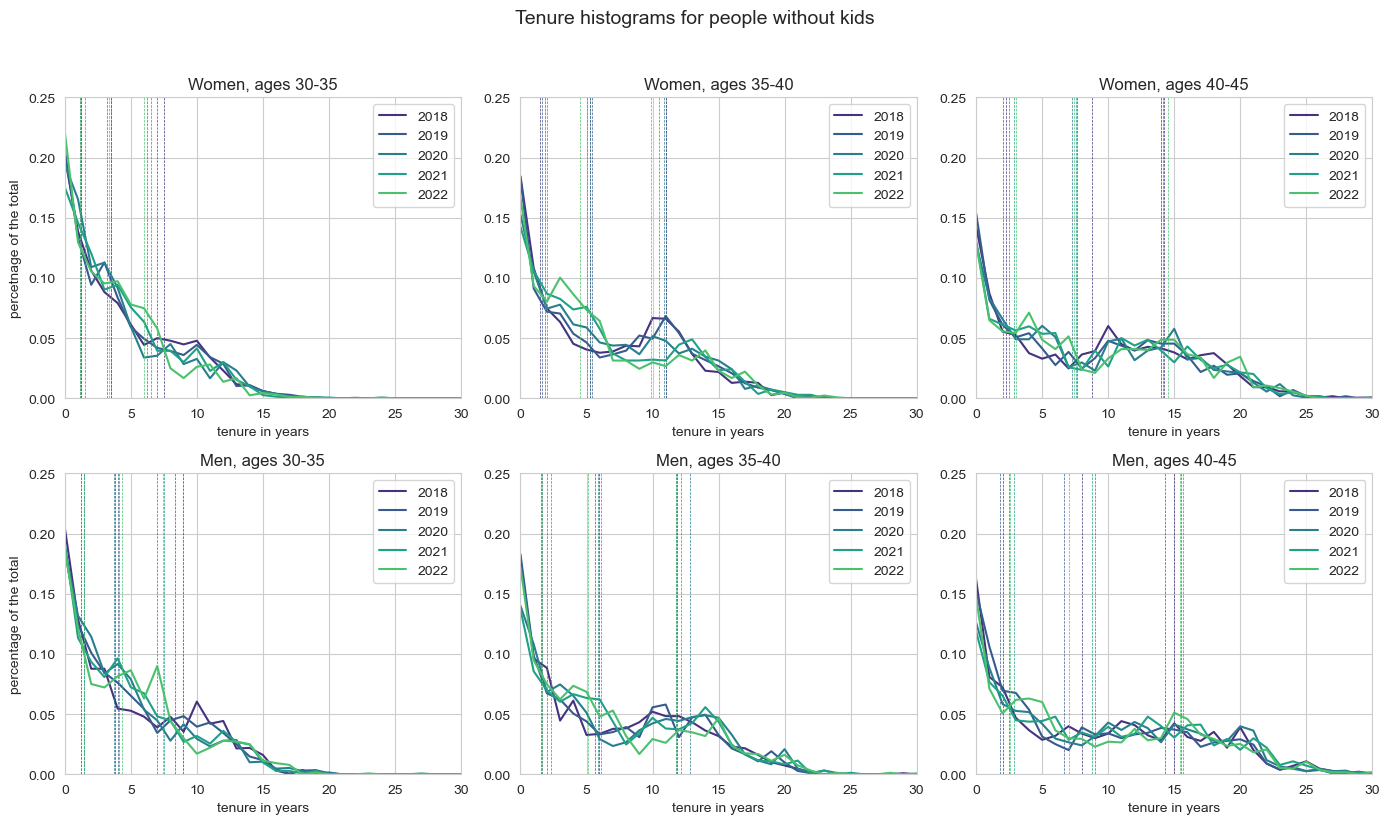

In [159]:
cs = sn.color_palette('viridis')
sn.set_palette(cs)

plt.figure(figsize=(14,8))
plt.suptitle('Tenure histograms for people without kids'.format(kid_age),y=1.025,fontsize=14)
data_fathers = ten_data[np.logical_and(ten_data['father_{}'.format(kid_age)]==0,ten_data['husband']==1)].copy()
data_mothers = ten_data[np.logical_and(ten_data['mother_{}'.format(kid_age)]==0,ten_data['wife']==1)].copy()
for j,age in enumerate([30,35,40]):
    plt.subplot(231+j)
    plt.title('Women, ages {}-{}'.format(age,age+5))
    for i,year in enumerate(years_range[-5:]):
        dta = data_mothers[np.logical_and(data_mothers['yd']==year,
                                          np.logical_and(data_mothers['edad5']>=age,
                                                         data_mothers['edad5']<age+5))]['ten_y'].copy()
        h, b = np.histogram(dta.values,bins=np.arange(0,45,1))
        plt.plot(b[:-1],h/np.sum(h),label=year)
        plt.axvline(dta.describe()['25%'],lw=0.5,ls='--',c=cs[i])
        plt.axvline(dta.describe()['50%'],lw=0.5,ls='--',c=cs[i])
        plt.axvline(dta.describe()['75%'],lw=0.5,ls='--',c=cs[i])
    plt.ylim(0,0.25)
    plt.xlim(0,30)
    plt.legend()
    plt.xlabel('tenure in years')
    if j==0:
        plt.ylabel('percetnage of the total')
for j,age in enumerate([30,35,40]):
    plt.subplot(234+j)
    plt.title('Men, ages {}-{}'.format(age,age+5))
    for i,year in enumerate(years_range[-5:]):
        dta = data_fathers[np.logical_and(data_fathers['yd']==year,
                                          np.logical_and(data_fathers['edad5']>=age,
                                                         data_fathers['edad5']<age+5))]['ten_y'].copy()
        h, b = np.histogram(dta.values,bins=np.arange(0,45,1))
        plt.plot(b[:-1],h/np.sum(h),label=year)
        plt.axvline(dta.describe()['25%'],lw=0.5,ls='--',c=cs[i])
        plt.axvline(dta.describe()['50%'],lw=0.5,ls='--',c=cs[i])
        plt.axvline(dta.describe()['75%'],lw=0.5,ls='--',c=cs[i])
    plt.ylim(0,0.25)
    plt.xlim(0,30)
    plt.legend()
    plt.xlabel('tenure in years')
    if j==0:
        plt.ylabel('percentage of the total')
plt.tight_layout()
plt.show()

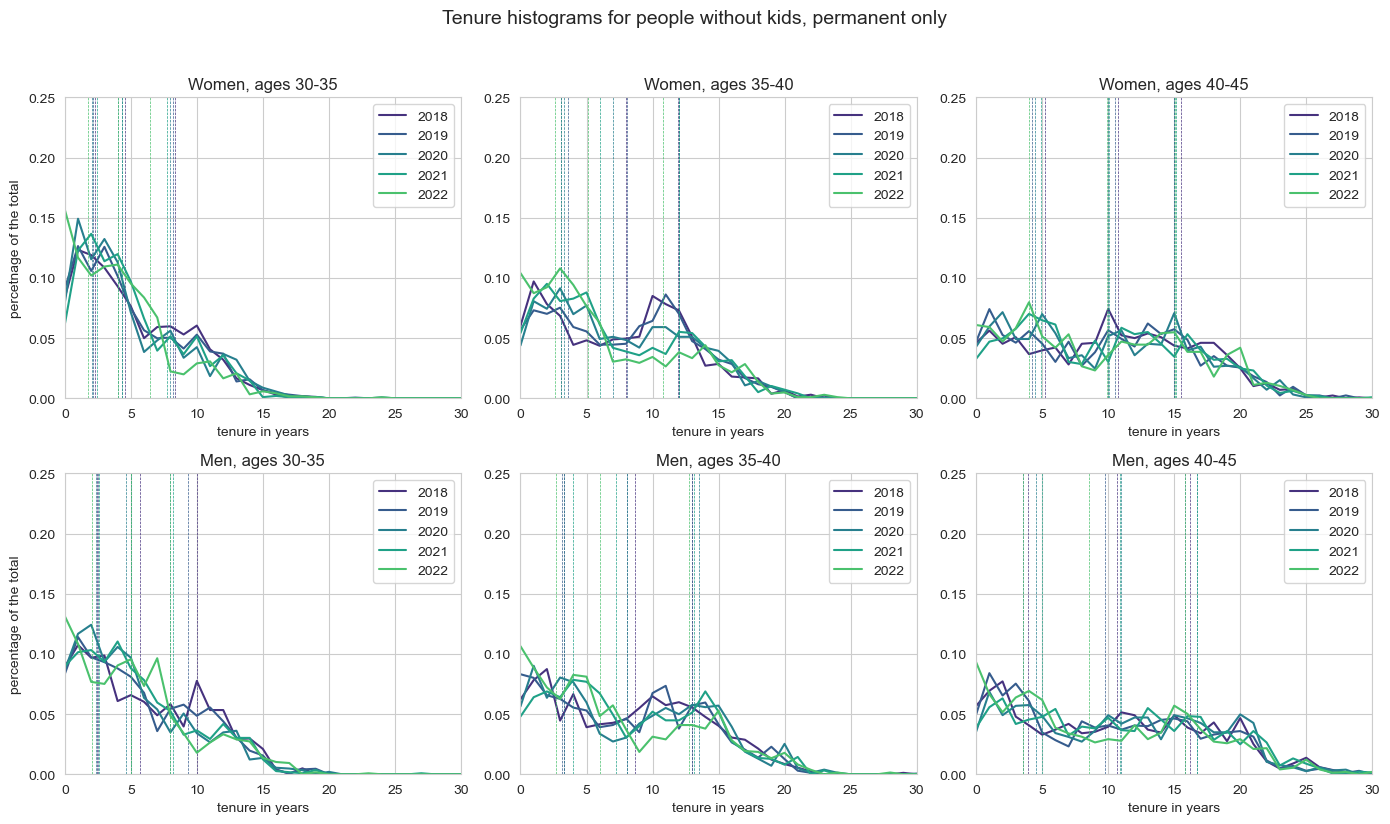

In [160]:
cs = sn.color_palette('viridis')
sn.set_palette(cs)

plt.figure(figsize=(14,8))
plt.suptitle('Tenure histograms for people without kids, permanent only'.format(kid_age),y=1.025,fontsize=14)
data_fathers = ten_data[np.logical_and(ten_data['father_{}'.format(kid_age)]==0,ten_data['husband']==1)].copy()
data_mothers = ten_data[np.logical_and(ten_data['mother_{}'.format(kid_age)]==0,ten_data['wife']==1)].copy()
for j,age in enumerate([30,35,40]):
    plt.subplot(231+j)
    plt.title('Women, ages {}-{}'.format(age,age+5))
    for i,year in enumerate(years_range[-5:]):
        dta = data_mothers[np.logical_and(data_mothers['yd']==year,np.logical_and(data_mothers['state']=='P',
                                          np.logical_and(data_mothers['edad5']>=age,
                                                         data_mothers['edad5']<age+5)))]['ten_y'].copy()
        h, b = np.histogram(dta.values,bins=np.arange(0,45,1))
        plt.plot(b[:-1],h/np.sum(h),label=year)
        plt.axvline(dta.describe()['25%'],lw=0.5,ls='--',c=cs[i])
        plt.axvline(dta.describe()['50%'],lw=0.5,ls='--',c=cs[i])
        plt.axvline(dta.describe()['75%'],lw=0.5,ls='--',c=cs[i])
    plt.ylim(0,0.25)
    plt.xlim(0,30)
    plt.legend()
    plt.xlabel('tenure in years')
    if j==0:
        plt.ylabel('percetnage of the total')
for j,age in enumerate([30,35,40]):
    plt.subplot(234+j)
    plt.title('Men, ages {}-{}'.format(age,age+5))
    for i,year in enumerate(years_range[-5:]):
        dta = data_fathers[np.logical_and(data_fathers['yd']==year,np.logical_and(data_fathers['state']=='P',
                                          np.logical_and(data_fathers['edad5']>=age,
                                                         data_fathers['edad5']<age+5)))]['ten_y'].copy()
        h, b = np.histogram(dta.values,bins=np.arange(0,45,1))
        plt.plot(b[:-1],h/np.sum(h),label=year)
        plt.axvline(dta.describe()['25%'],lw=0.5,ls='--',c=cs[i])
        plt.axvline(dta.describe()['50%'],lw=0.5,ls='--',c=cs[i])
        plt.axvline(dta.describe()['75%'],lw=0.5,ls='--',c=cs[i])
    plt.ylim(0,0.25)
    plt.xlim(0,30)
    plt.legend()
    plt.xlabel('tenure in years')
    if j==0:
        plt.ylabel('percentage of the total')
plt.tight_layout()
plt.show()

In [167]:
kid_age = 10

data_fathers = ten_data[np.logical_and(ten_data['father_{}'.format(kid_age)]==1,ten_data['husband']==1)].copy()
data_mothers = ten_data[np.logical_and(ten_data['mother_{}'.format(kid_age)]==1,ten_data['wife']==1)].copy()

diff_first_gross_w, diff_first_w = np.zeros((3,5)),np.zeros((3,5))
diff_first_gross_m, diff_first_m = np.zeros((3,5)),np.zeros((3,5))
for j,age in enumerate([30,35,40]):

    for i,year in enumerate(years_range[-5:]):
        dta = data_mothers[np.logical_and(data_mothers['yd']==year,np.logical_and(data_mothers['state']=='P',
                                          np.logical_and(data_mothers['edad5']>=age,
                                                         data_mothers['edad5']<age+10)))]['ten_y'].copy()
        h, b = np.histogram(dta.values,bins=np.arange(0,45,3))
        diff_first_gross_w[j,i], diff_first_w[j,i] = h[0], h[0]/np.sum(h)
        
        dta = data_fathers[np.logical_and(data_fathers['yd']==year,np.logical_and(data_fathers['state']=='P',
                                          np.logical_and(data_fathers['edad5']>=age,
                                                         data_fathers['edad5']<age+5)))]['ten_y'].copy()
        h, b = np.histogram(dta.values,bins=np.arange(0,45,3))
        diff_first_gross_m[j,i], diff_first_m[j,i] = h[0], h[0]/np.sum(h)

diff_first_gross_w = diff_first_gross_w[:,1:] - diff_first_gross_w[:,:-1]
diff_first_gross_m = diff_first_gross_m[:,1:] - diff_first_gross_m[:,:-1]
diff_first_w = diff_first_w[:,1:] - diff_first_w[:,:-1]
diff_first_m = diff_first_m[:,1:] - diff_first_m[:,:-1]

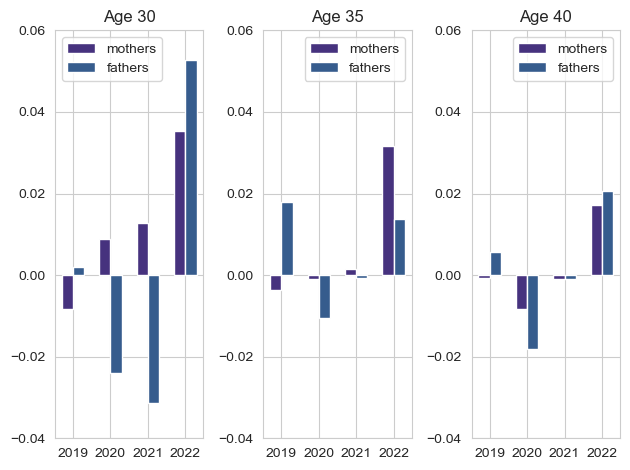

In [179]:
ww = 0.3
for j,age in enumerate([30,35,40]):
    plt.subplot(131+j)
    plt.title('Age {}'.format(age))
    plt.bar(np.arange(4),diff_first_w[j,:], width=ww,label='mothers')
    plt.bar(np.arange(ww,4+ww),diff_first_m[j,:], width=ww,label='fathers')
    plt.legend()
    plt.ylim(-0.04,0.06)
    plt.xticks(np.arange(ww/2,4+ww/2),years_range[-4:])
plt.tight_layout()
plt.show()

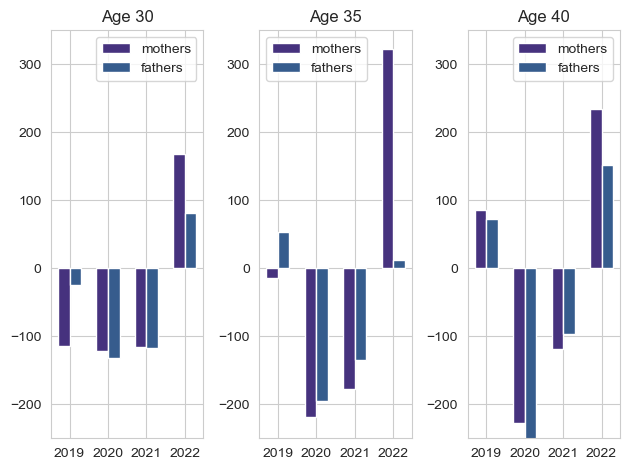

In [182]:
ww = 0.3
for j,age in enumerate([30,35,40]):
    plt.subplot(131+j)
    plt.title('Age {}'.format(age))
    plt.bar(np.arange(4),diff_first_gross_w[j,:], width=ww,label='mothers')
    plt.bar(np.arange(ww,4+ww),diff_first_gross_m[j,:], width=ww,label='fathers')
    plt.legend()
    plt.ylim(-250,350)
    plt.xticks(np.arange(ww/2,4+ww/2),years_range[-4:])
plt.tight_layout()
plt.show()

In [166]:
diff_first_m[:,1:] - diff_first_m[:,:-1]

array([[ 0.00197691, -0.024091  , -0.0313093 ,  0.05280561],
       [ 0.01786827, -0.01058697, -0.00060916,  0.01379939],
       [ 0.00565145, -0.01801911, -0.00099028,  0.02055556]])